In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('C:/Users/Fabian/gempy')
#sys.path.insert(1,'/home/fabian/gempy')
import gempy as gp

C:/Users/Fabian/gempy\gempy\data_management.py:34: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')


In [3]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

#import vtk
#import evtk

from scipy.interpolate import griddata

In [4]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa
import gempy.utils.decision_making as dm

In [5]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = ".././input_data/Fab_ResModel_Foliations2.csv",
                        path_i = ".././input_data/Fab_ResModel_Points4_small_offset.csv")
                         #path_i = ".././input_data/Fab_ResModel_finite_fault.csv")
geo_data.n_faults = 1

In [6]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

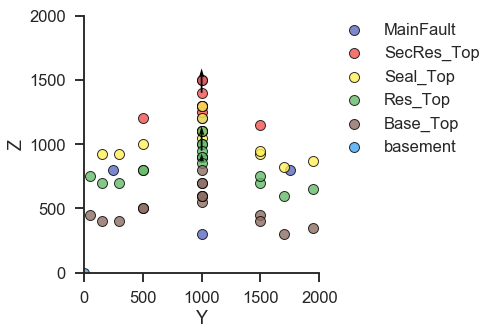

In [7]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data, direction='x')

In [8]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [9]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [10]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients',
                                 compile_theano=True, dtype ='float64', theano_optimizer='fast_run')

Compiling theano function...


C:\Users\Fabian\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\Fabian\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\Fabian\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not a

Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1


In [11]:
#interp_data.interpolator.tg.inf_factor.set_value(np.zeros(7, dtype='int32'))
#interp_data.interpolator.tg.inf_factor.get_value()

In [12]:
type(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values)

numpy.ndarray

In [13]:
import pandas as pd

In [14]:

# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [15]:
gp.get_kriging_parameters(interp_data)

range 0.888231183368655 3464.101615137755
Number of drift equations [3 3]
Covariance at 0 0.018784634169249557
orientations nugget effect 0.01
scalar nugget effect 1e-06


In [16]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

#lith_block = np.round(lith_sol[0]).reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])
#
##fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
##                                     geo_data.resolution[1],geo_data.resolution[2])
#fault_block_0 = np.round(fault_sol[0])#.astype(int)
#fault_block = fault_block_0.reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])

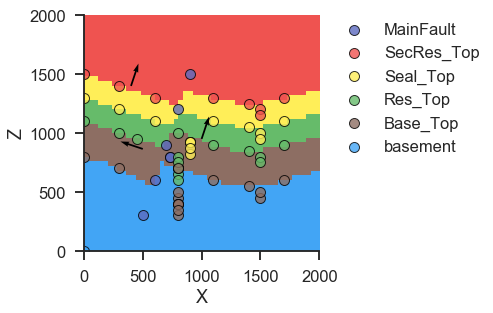

In [17]:
gp.plotting.plot_section(geo_data, lith_sol[0], 25, plot_data=True)

In [18]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [19]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n-1)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n-1)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n-1)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n-1)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n-1)

In [20]:
fault_plot = fa.PlotFault2D(geo_data)

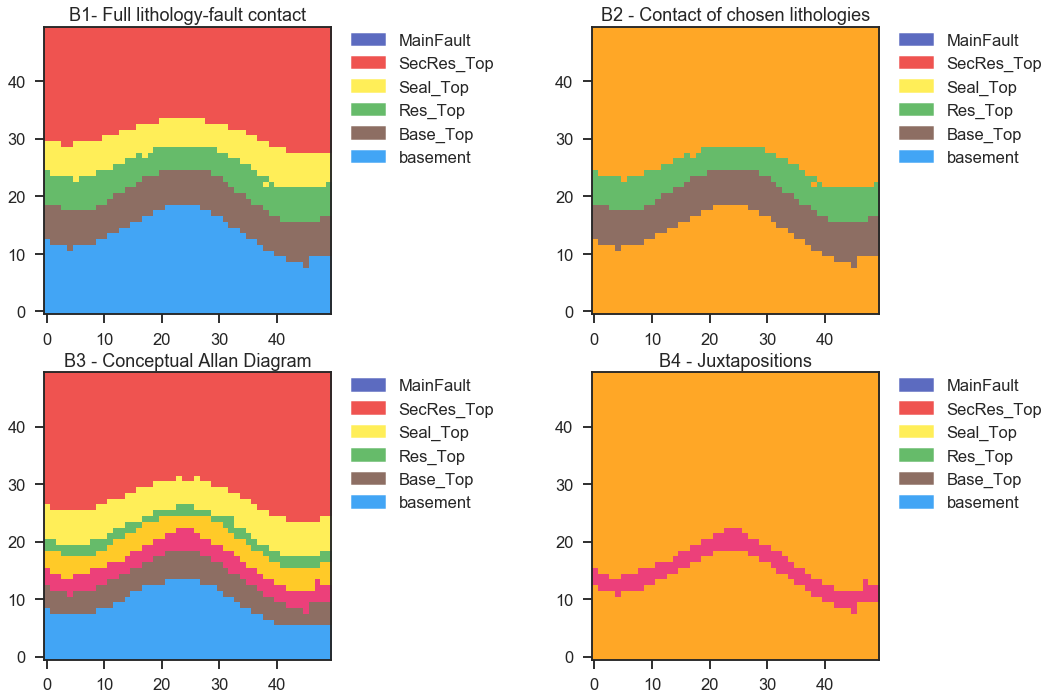

In [21]:
figsize(18,18)

plt.subplot(321)
plt.title('B1- Full lithology-fault contact')
fault_plot.plot_lith_fault_contact_full(lith_sol, fault_sol, fault_n, fault_side='footwall')

plt.subplot(322)
plt.title('B2 - Contact of chosen lithologies')
fault_plot.plot_lith_fault_contact(lith_sol, fault_sol, fault_n, lith_n=[seal_n, res_n], fault_side='footwall')

plt.subplot(323)
plt.title('B3 - Conceptual Allan Diagram')
fault_plot.plot_AllanDiagram(lith_sol, fault_sol, fault_n, lith_target=[res_n], lith_jux=[res_n], target_side='fw')

plt.subplot(324)
plt.title('B4 - Juxtapositions')
fault_plot.plot_juxtapositions(lith_sol, fault_sol, fault_n, lith_target=[res_n], lith_jux=[res_n], target_side='fw');

In [22]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [23]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

permeable_l = [secres_n, over_n]

In [24]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

In [25]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
#gp.plotting.plot_section(geo_data, lith_block, int(resolution/2), plot_data=1, direction='y')
#plt.savefig('computed_block.pdf', transparent=True)

In [26]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

In [27]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith, fault, bottom_z, formation_bool, fault_bool):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5).astype(int) #rounding up to avoid voxel connection to outside borders
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(geo_data, lith, fault, seal_th, trap_n):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
        gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 0)
    trap_keys = [int(k) for k in lith_to_labels_lot["%s" % trap_n].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["0"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    #gp.topology.classify_edges(G, centroids, lith.reshape(resolution,resolution,resolution), fault.reshape(resolution,resolution,resolution))   
    gp.topology.classify_edges(G, centroids, lith_pad, fault_pad)   
    # If too many traps, model probably broken:
    print("NUMBER OF POTENTIAL TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        print('Too many traps detected. Reservoir discontinuous or model probably broken.')
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                traps.append(tk)
                print('TRAP CONFIRMED:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [28]:
# get juxtaposition with itself
def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n):
    hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
    maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
    if np.any(maxline_hw):
        max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z
        return max_jux
    else:
        return 0

#def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
#                        res_n):
#    juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
#                        lith_target=res_n, lith_jux=res_n, target_side='fw', projection='automatic')
#    if np.any(juxta):
#        max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
#        return max_jux
#    else:
#        return 0

In [29]:
#hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
#maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
#if np.any(maxline_hw):
#    max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z

In [30]:
# get juxtapositions with any other input perm layers
def perm_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, lith_perm):
    if isinstance(lith_perm, int):
        lith_perm = [lith_perm]
    juxta_list = np.zeros((len(lith_perm),2))
    juxta_list[:,0] = np.array(lith_perm)
    for i in lith_perm:
        juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, i, target_side='fw', projection='automatic')
        if np.any(juxta):
            max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
            juxta_list[(np.argwhere(juxta_list[:,0]==i)),1] = max_jux
    juxta_list = np.delete(juxta_list, np.argwhere(juxta_list[:,1]==0), 0)
    return juxta_list        

In [31]:
# get SSF on base of fault analysis module
def fa_SSF(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position='faultmax_argrelmax', order=40):
    fault_throws = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position=position, order=order, artifact_filter='on')
    max_throw = np.nanmax(fault_throws)
    contact = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw')
    proj = fa.project_voxels(contact, form='2D')
    lith_thickness = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw',
                      position=position, order=order)
    min_thickness = np.nanmin(lith_thickness)
    SSF = max_throw/min_thickness
    print('SSF = %s / %s = %s' % (max_throw, min_thickness, SSF))
    return SSF

In [32]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps
def max_trap_vol(geo_data, interp_data, lith_sol, fault_sol, res_n, seal_n, fault_n, GX, GY, seal_surf_v):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    trap_n = (np.max(formation_numbers)+1)
    
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]
    
    seal_thickness_all = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, 
                                                 seal_n, fault_n, fault_side='fw',
                      position='faultmax_argrelmax', order=40)
    seal_thickness = np.nanmin(seal_thickness_all)
    
    seal_thresh = vox_size_z
    if seal_thickness < seal_thresh:
        print("Seal layer compromised, too thin.")
        print('CONTROL: STRAT. SEAL BREACH')
        # Trap failed due to assumed seal cap discontinuity: return no volume, no trap, SSF = nan
        return 0, np.zeros_like(lith_block), np.nan, 4    

    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    highest_spill_point = sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY)
    
    if highest_spill_point == []:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith_block)
        return trap_vol, final_trap_mask, np.nan, 0
    
    spill_z = np.max(highest_spill_point[2])
    leak_self_z = self_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n)
    # need to implement variability of permeable layers
    juxta_above = perm_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n, lith_perm=permeable_l)
    
    print('SPILL POINT COORDINATES:', highest_spill_point)
    print('LEAK SELF Z-POSITION:', leak_self_z)
    print('JUXTA with permable layers:', juxta_above)

    SSF_c = 3
    SSF = fa_SSF(geo_data, lith_sol, fault_sol, seal_n, fault_n,
                      position='faultmax_argrelmax', order=40)
    if SSF > SSF_c:
        print('SSF threshold exceeded, shale smear assumed to be incomplete.')
        SSF_sealing = False
    else: 
        print('SSF in confidence range, complete shale smear sealing assumed.')
        SSF_sealing = True
        
    #general_sealing = False # might be implemented later (as binomial probability)
    
    if juxta_above.size == 0:
        leak_z = leak_self_z
        # no SSF necessary (but still have to be calculated if relevant in probabilistic model)
        # possible use of general fault sealing probability
        max_z = np.nanmax([spill_z, leak_z])  
        if max_z == spill_z:
            trap_control = 1
            print('CONTROL: SPILL Z')
        else:
            trap_control = 2
            print('CONTROL: LEAK Z')
    else:
        # check for SSF/general sealing
        if SSF_sealing == False: 
            leak_above_z = np.max(juxta_above[:,1])
            max_z = np.nanmax([spill_z, leak_above_z]) 
            if max_z == spill_z:
                trap_control = 1
                print('CONTROL: SPILL Z')
            else:
                trap_control = 3
                print('CONTROL: PERM. JUXTA Z')
        #elif general_sealing == False:
        #    max_z = np.nanmax([spill_z, leak_self_z])
        #    if max_z == spill_z:
        #        trap_control = 1
        #    else:
        #        trap_control = 2   
        else:
            max_z = spill_z
            trap_control = 1
            print('CONTROL: SPILL Z')
            
    ### MAKE AN OWN FUNCTION TO GET MAX_Z!              
        
    rounded_lith = np.around(lith_block).astype(int)
    rounded_fault = np.around(fault_block).astype(int)
    res_n_bool = rounded_lith == res_n
    fault_bool = rounded_lith == 2
        
    pre_trap_mask = res_mask(lith_block, fault_block, max_z, res_n_bool, fault_bool)
          
    # volume cells for counting
    vol_cells = 0
    lith_copy = np.copy(lith_block)
        
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        #trap_control = 0
        return 0, pre_trap_mask, SSF, trap_control
    else:
        lith_copy[pre_trap_mask_bool] = trap_n                           # setting reservoir above bottom on footwall side 
        final_trap_mask = topo_analysis(geo_data, lith_copy, fault_block, seal_thickness, trap_n)
        lith_copy[final_trap_mask] = (trap_n + 1)                        # setting final trap to formation value = trap_n + 1
        vol_cells = np.count_nonzero(final_trap_mask)
            
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        # revert to lith_block without any masks
        #lith[pre_trap_mask_bool] = res_n      
        #return the maximum reservoir volume
        return trap_vol, final_trap_mask, SSF, trap_control

In [33]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

### Setting up the probabilistic model

In [34]:
lith_unc_stds = np.array([40,60,80,100])
# NEXT: create a Z modifier through which we can loop

In [36]:
lith_ids = geo_data.interfaces["formation"].dropna().unique()[1:-1]
print(lith_ids)

[SecRes_Top, Seal_Top, Res_Top, Base_Top]
Categories (6, object): [MainFault, SecRes_Top, Seal_Top, Res_Top, Base_Top, basement]


In [37]:
lith_numbers = geo_data.formations.formation_number[1:]

In [38]:
lith_Z_modifier = []

for liID, stdi in zip(lith_ids, lith_unc_stds):
    stoch = pymc.Normal(liID+'_stoch', 0, 1./np.square(stdi/rescale_f))
    lith_Z_modifier.append(stoch)

In [39]:
faultside_ids = geo_data.interfaces["fault side"].dropna().unique()
print(faultside_ids)

['nan' 'hanging wall' 'footwall']


In [40]:
std_offset = 150
fault_Z_modifier = pymc.SkewNormal(faultside_ids[1]+'offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


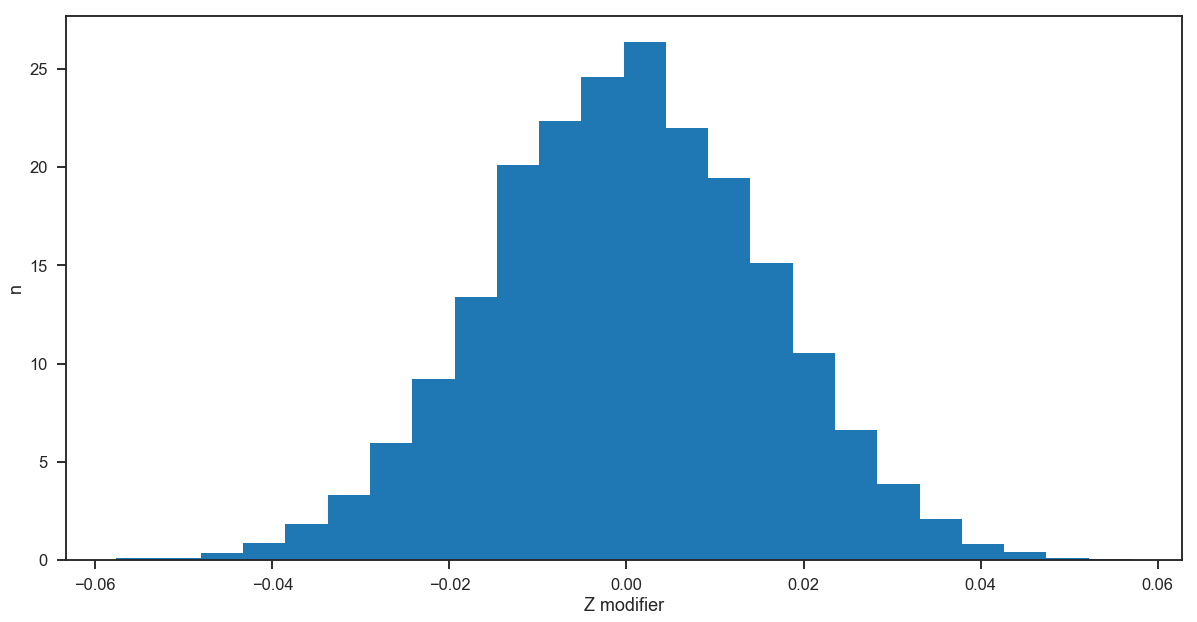

In [41]:
# sample from a distribution
samples = [lith_Z_modifier[1].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

In [42]:
import copy
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)
#interp_data_stoch_init = copy.deepcopy(interp_data)

In [43]:
# NEW INTERP FUNCTION
@pymc.deterministic(trace=True)
def input_data(value=0, geo_data_stoch_init=geo_data_stoch_init, lith_Z_modifier=lith_Z_modifier, 
              fault_Z_modifier=fault_Z_modifier, verbose= 0):
    
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    for e, foID in enumerate(lith_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == foID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(lith_Z_modifier[e])
        
    sel_fa = gp.get_data(interp_data.geo_data_res, verbosity=2)['fault side'] == 'hanging wall'
    geo_data_stoch.loc[sel_fa, 'Z']  += np.array(fault_Z_modifier)
    
    if verbose > 0:
        print(geo_data_stoch)
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

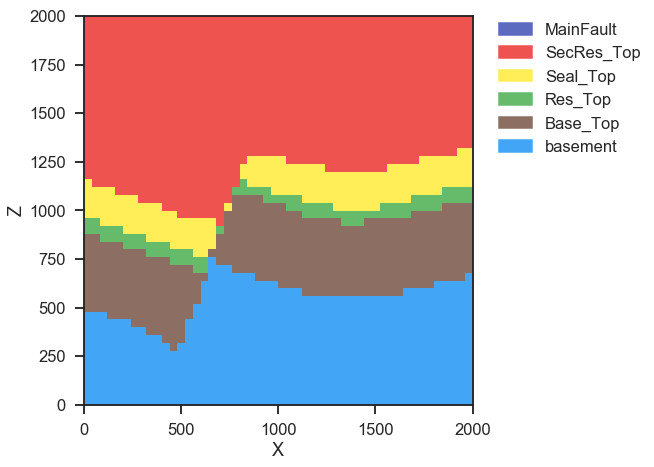

In [44]:
@pymc.deterministic(trace=False)
def gempy_model(value=0, input_data=input_data, seal_n=seal_n, print_figures=True):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    try:
        # try to compute model
        ls, fs = gp.compute_model(interp_data)
        if print_figures:
            gp.plot_section(geo_data, ls[0], np.int(resolution/2), plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return ls, fs, interp_data
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_sol), np.zeros_like(fault_sol), interp_data

In [45]:
gp.get_kriging_parameters(interp_data)

range 0.888231183368655 3464.101615137755
Number of drift equations [3 3]
Covariance at 0 0.018784634169249557
orientations nugget effect 0.01
scalar nugget effect 1e-06


In [46]:
@pymc.deterministic(trace=True)
def trap_analysis(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1], 
                  interp_data=gempy_model[2], print_figures=False, verbose = False):
    
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    try:
        max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return max_vol, SSF, trap_control
    
    except (IndexError, ValueError):
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose == True:
            print("Exception occured.")
        return np.nan, np.nan, np.nan
#@pymc.deterministic(trace=True)
#def trap_analysis(value=0, input_data=input_data, print_figures=False):
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
#                                           'dip', 'azimuth', 'polarity']] = input_data[1]
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)    
#    try:
#        # try to compute model
#        lith_sol, fault_sol = gp.compute_model(interp_data)
#        if print_figures:
#            gp.plot_section(interp_data.geo_data_res, lith_sol[0], np.int(resolution/2), plot_data=True)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.nan, np.nan, np.nan
#    
#    seal_surf_V = gp.get_surfaces(\
#        interp_data = interp_data, potential_lith=lith_sol[1], \
#        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
#    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
#    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
#                                                    lith_sol, fault_sol, res_n, 
#                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
#    print("Maximum trap volume: %s m³" % max_vol)
#    if print_figures:
#        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
#    return max_vol, SSF, trap_control

No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          921.08802795]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
TRAP VOXELS: 0
Maximum trap volume: 0 m³


In [47]:
def trap_analysis_post(lith_sol, fault_sol, print_figures=False):
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]  
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
    print("Maximum trap volume: %s m³" % max_vol)
    print('TRAP VOXELS:', np.count_nonzero(trap))
    if print_figures:
        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return max_vol, SSF, trap_control # trap --> what to do about trap return?

In [48]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

In [49]:
# Reservoir thickness
@pymc.deterministic(trace=True)
def thicknesses(value=0, input_data=input_data):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    res_th = np.abs(fw_sb_z-fw_rb_z)
    seal_th = np.abs(fw_r2b_z-fw_sb_z)
    secres_th = np.abs(fw_ob_z-fw_r2b_z) 
    return res_th, seal_th, secres_th

#Seal thickness
#@pymc.deterministic(trace=True)
#def seal_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_r2b_z-fw_sb_z)
#
## Secondary reservoir thickness
#@pymc.deterministic(trace=True)
#def sec_res_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_ob_z-fw_r2b_z) 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [50]:
iterations = 10

In [51]:
params = [input_data, thicknesses, gempy_model, trap_analysis, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [52]:
dbname="trapmodel_lithSIMPLEMC4"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations2"+".hdf5"

In [53]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)
#RUN = pymc.MCMC(model)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          720.53260803]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
TRAP VOXELS: 264
Maximum trap volume: 16896000.0 m³
 [-------          20%                  ] 2 of 10 complete in 3.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          728.44398499]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 40.0 / 320.0 = 0.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
TRAP VOXELS: 8
Maximum trap volume: 512000.0 m³
 [-----------      30%                  ] 3 of 10 complete in 7.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [---------------  40%                  ] 4 of 10 complete in 9.7 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          787.90710449]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 40.0 / 160.0 = 0.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
TRAP VOXELS: 0
Maximum trap volume: 0.0 m³
 [-----------------50%                  ] 5 of 10 complete in 12.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          893.83132935]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [-----------------60%--                ] 6 of 10 complete in 15.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.         920.         956.6771698]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 40.0 = 5.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
TRAP VOXELS: 0
Maximum trap volume: 0.0 m³
 [-----------------70%------            ] 7 of 10 complete in 17.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          852.15827942]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [-----------------80%----------        ] 8 of 10 complete in 20.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          854.59724426]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 80.0 = 3.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [-----------------90%--------------    ] 9 of 10 complete in 22.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [-----------------100%-----------------] 10 of 10 complete in 24.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          852.25906372]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
TRAP VOXELS: 0
Maximum trap volume: 0 m³
 [------------------110%-------------------] 11 of 10 complete in 26.9 sec

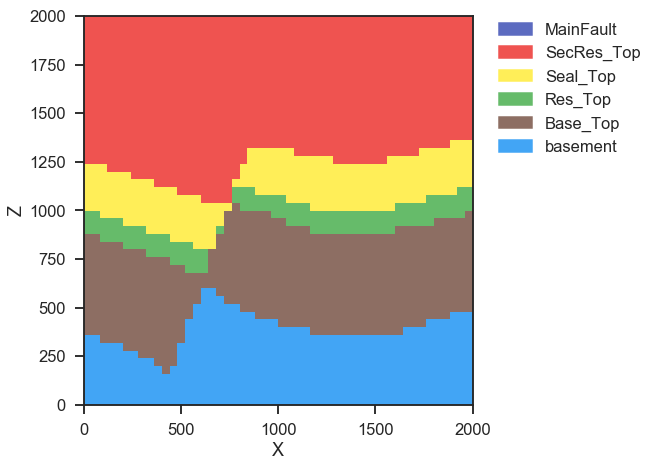

In [54]:
RUN.sample(iter=iterations)

# POST ANALYSIS

In [55]:
post = gp.posterior_analysis.Posterior(dbname)

In [56]:
ta_trace = post.db.trace('trap_analysis')

In [57]:
vol_trace = post.db.trap_analysis[:][:,0]
trap_control_trace = post.db.trap_analysis[:][:,2]

In [58]:
#figsize(16, 6)
#
## Possibly mask away complete failures:
##volumes = max_volume_trace
##mask = volumes == 0
##masked_trace = volumes[~mask]
#
#_hist1 = plt.hist(vol_trace, bins=100, normed=True, 
#                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
#plt.vlines(vol_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
#plt.vlines(np.median(vol_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
#plt.title("Prior trap volume distribution")
#plt.legend(loc="upper right")
##plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
#plt.grid()
#plt.ylim(0, 1.1 * np.max(_hist1[0]))
#plt.xlabel("Volume [m³]")
#plt.ylabel("Probability")

In [59]:
trap_control_trace

array([1., 2., 4., 2., 3., 3., 3., 3., 4., 3.])

In [60]:
# COUNT TRAP CONTROL OCCURRENCES
uniques, counts = np.unique(trap_control_trace, return_counts=True)
counts = np.round((counts/iterations)*100)

labels = ('UNCLEAR', 'SPILL POINT', 'LEAK UNDER', 'LEAK OVER', 'STRAT')
trap_base = dict(zip(labels, [0,0,0,0,0]))
trap_controls = dict(zip(labels, counts))

In [61]:
counts

array([10., 20., 50., 20.])

In [62]:
post.change_input_data(interp_data, 0)
interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
lith_block, fault_block = gp.compute_model(interp_data)

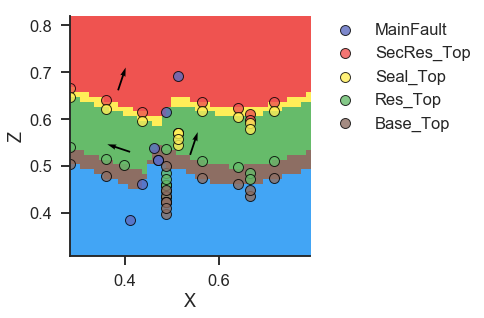

In [63]:
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, direction='y', plot_data=True)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          720.53260803]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 16896000.0 m³
TRAP VOXELS: 264


(16896000.0, 1.7142857142857142, 1)

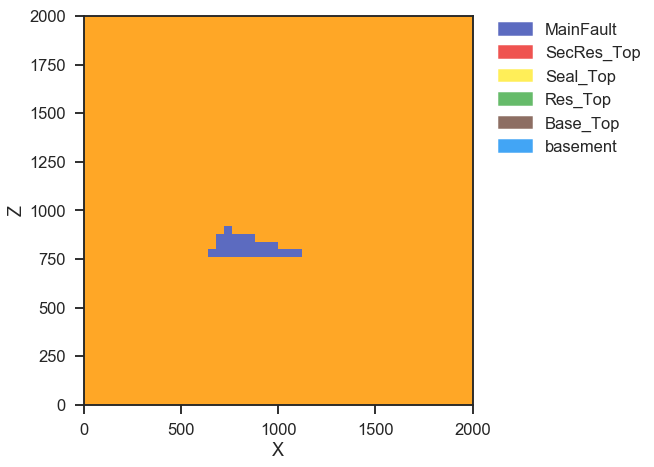

In [64]:
trap_analysis_post(lith_block, fault_block, print_figures=True)

In [65]:
post.db.trap_analysis[:]

array([[1.68960000e+07, 1.71428571e+00, 1.00000000e+00],
       [5.12000000e+05, 1.25000000e-01, 2.00000000e+00],
       [0.00000000e+00,            nan, 4.00000000e+00],
       [0.00000000e+00, 2.50000000e-01, 2.00000000e+00],
       [0.00000000e+00, 7.00000000e+00, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 3.00000000e+00],
       [0.00000000e+00, 6.00000000e+00, 3.00000000e+00],
       [0.00000000e+00, 3.50000000e+00, 3.00000000e+00],
       [0.00000000e+00,            nan, 4.00000000e+00],
       [0.00000000e+00, 9.00000000e+00, 3.00000000e+00]])

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          720.53260803]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 16896000.0 m³
TRAP VOXELS: 264
No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          728.44398499]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 40.0 / 320.0 = 0.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 512000.0 m³
TRAP VOXELS: 8
Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
TRAP VOXELS: 0
No maxima found for

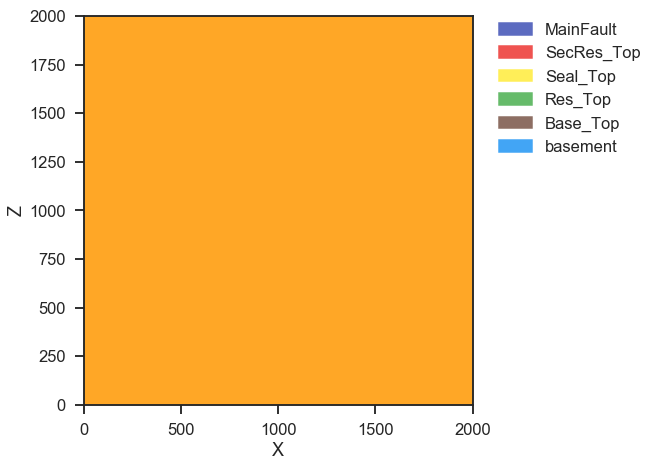

In [66]:
vol, SSF, tc = [],[],[]
for i in np.arange(post.db.input_data.length()):
    post.change_input_data(interp_data, i)
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    lith_sol, fault_sol = gp.compute_model(interp_data)
    #gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, plot_data=True)
    v,s,c = trap_analysis_post(lith_sol, fault_sol, print_figures=True)
    vol.append(v)
    SSF.append(s)
    tc.append(c)

In [67]:
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    gp.plotting.plot_section(interp_data.geo_data_res, lith_sol[0], 25, plot_data=True)

# POSTERIOR MODEL

In [ ]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic(trace=True)
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(thicknesses[2], 150., 1./np.square(std1))

@pymc.stochastic(trace=True)
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(thicknesses[1], 350., 1./np.square(std2))

@pymc.stochastic(trace=True)
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(thicknesses[0], 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic(trace=True)
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [65]:
iterations = 50

In [66]:
params = [input_data, thicknesses, gempy_model, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [67]:
dbname="trapmodel_lithTH"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"

In [68]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)

In [69]:
RUN.sample(iter=iterations)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [---              10%                  ] 5 of 50 complete in 0.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [------           16%                  ] 8 of 50 complete in 1.3 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------         22%                  ] 11 of 50 complete in 1.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------      30%                  ] 15 of 50 complete in 2.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------------   38%                  ] 19 of 50 complete in 2.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------46%                  ] 23 of 50 complete in 3.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------56%-                 ] 28 of 50 complete in 4.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------66%-----             ] 33 of 50 complete in 4.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------74%--------          ] 37 of 50 complete in 5.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------82%-----------       ] 41 of 50 complete in 5.7 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------90%--------------    ] 45 of 50 complete in 6.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------100%-----------------] 50 of 50 complete in 6.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------100%-----------------] 50 of 50 complete in 6.9 sec

In [ ]:
likelihoods = "thickness" # choose which likelihoods to use: "thickness", "SSF" or "both"

if likelihoods == "thickness":
    # Model inclucing only thickness likelihoods
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
elif likelihoods == "SSF":    
    # Model including only SSF likelihood
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, SSF_likelihood])
elif likelihoods == "both":
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, 
                          sec_res_th_likelihood, SSF_likelihood])
else:
    print("Did not understand which likelihood functions to use.")

In [ ]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [ ]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
#CUSTOM LOSS FUNCTION
estimates_s = np.arange(0,60000000, 10000)

# weight factors
o = 1.25
o_f = 2
u_f = 1.5

# risk factor range
risks_s = np.arange(0.5, 1.6, 0.25)


In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s,
                      true_s=max_volume_trace,
                      risk_range=risks_s,o=o,o_f=o_f,u_f=u_f)

In [ ]:
iterations=20

In [ ]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=0)

In [ ]:
#M_L.db.commit()
#M_L.db.close()

In [ ]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

structural_model_trace_L = M_L.trace('structural_model')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s, true_s=max_volume_trace_L,
                     risk_range=risks_s, o=o, o_f=o_f, u_f=u_f)

In [ ]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()